In [191]:
import pandas as pd 
import numpy as np
import os
import random
import math 
import copy

from scipy.special import lambertw 
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import plotly.graph_objects as go 

plt.rcParams.update({'font.size': 15})
plt.rc('font',family='Times New Roman')

random.seed = 1

# Define Optimal Group Size Function and Performance Indicators 

## Optimal Group Size Function

In [192]:
# Caculate optimal group size without integer constraints and dilution effects
def Find_N_0(se,sp,p): 

  if (p <= 0):
      return 0 
  p_b = 1 -  np.exp((-1)*(se+sp-1)/(np.exp(1)))
  if p <= p_b:
      x = (-1/2)*np.sqrt(np.log(1/(1-p))/(se+sp-1)) 
      n_0 =np.real(2/(np.log(1-p))*lambertw(x))
  else:
      n_0 = 1
  return n_0

# Caculate optimal group size with integer constraints and dilution effects
def Find_Int_N(se,sp,n_0,p):  

  if(n_0 == 1):
      n_opt = 1
      cpr_i = CPR(se,sp,1,p)
      cpr_opt = CPR(se,sp,1,p)
  else:
      cpr_i = CPR(se,sp,1,p)
      cpr_g_d = CPR(se,sp,np.floor(n_0),p)
      cpr_g_u= CPR(se,sp,np.ceil(n_0),p)

      n_list = [np.floor(n_0),np.ceil(n_0),1,]
      cpr_list = [cpr_g_d,cpr_g_u,cpr_i,]
      n_opt = min(n_list[np.argmin(cpr_list)],32)
      
  cpr_opt = CPR(se,sp,n_opt,p)
  # print(n_opt,cpr_opt,cpr_i)
  
  return n_opt,cpr_opt,cpr_i


## Performance Indicators 

In [193]:

# Caculate efficiency (see supplementary for mathematical derivations)
def Eff(se,sp,n,p):

  if n <= 1:
      EN = 1
  else: 
      EN = 1/n + se-(se+sp-1)*(1-p)**n
  return EN

# Caculate CPR (see supplementary for mathematical derivations)
def CPR(se,sp,n,p):
  
  if (p == 0):
    cpr_n = 10000
    return cpr_n
  else:
    if n <= 1:
        cpr_n = 1/(se*p)
    else:
        cpr_n = Eff(se,sp,n,p)/(se**2*p)
    return cpr_n
    
# Caculate positive predictive value, negative predictive value,
# expected number of false positives and expected number of true positive 
# (see supplementary for mathematical derivations) 
def PV(se, sp, n, p):

  if n == 0:
    PPV,NPV,TP,FP = 0,0,0,0
    return PPV,NPV,TP,FP

  if n == 1:
      TP = se*p
      FP = (1-p)*(1-sp)
      
      TN = sp*(1-p)
      FN = p*(1-se)
      
      PPV = TP/(TP+FP)
      NPV = TN/(TN+FN)
      
  else:
      
      TP = se**2*p
      FP = se*(1-p)*(1-sp)-(1-sp)*(se+sp-1)*(1-p)**n
      
      TN = (1-p) - FP
      FN = p - TP
      
      
      PPV = TP/(TP+FP)
      NPV = TN/(TN+FN)
      
  return PPV,NPV,TP,FP

# Figure 1 Caculation and Figure Production

## Calculation for Figure 1 

In [194]:
# Data source is https://covidtracking.com
# Note that Johns Hopkins University COVID-19 Database contains testing data of all 50 US states and 6 territories in different parts of the world, outside of the 50 main states in the Union.
data = pd.read_csv('./0822-0828_posrate_7_days.csv')  

In [195]:
new_columns = ['N_0_Se_0.7', 'CPR_Se_0.7', 'N_0_Se_0.95', 'CPR_Se_0.95', 'N=1_CPR'] 
for col in new_columns:
    data[col] = None   

In [196]:
S_e = [0.7, 0.95] 
S_p = 0.95 

# Calculation for Figure 1 
for i in range(len(data)):
  p_7day_mean = data.iloc[i, 1]
  N_0 = Find_N_0(se = S_e[0], sp = S_p, p = p_7day_mean)
  if (p_7day_mean>0):
    N_opt,cpr_opt,cpr_i = Find_Int_N(se = S_e[0], sp = S_p, n_0= N_0,p= p_7day_mean)
  else:
    # When p=0, group size reachs its maximum value M = 32. 
    N_opt,cpr_opt,cpr_i = 32,10000,10000
  # N_opt is shown in Figure B1 
  data.iloc[i, 2] = N_opt
  # cpr_opt is shown in Figure B2 
  data.iloc[i, 3] = cpr_opt 

  N_0 = Find_N_0(se = S_e[1], sp = S_p, p = p_7day_mean)  
  N_opt,cpr_opt,cpr_i2 = Find_Int_N(se = S_e[1], sp = S_p, n_0= N_0, p= p_7day_mean)
  # N_opt is shown in Figure C1 
  data.iloc[i,4] = N_opt
  # cpr_opt is shown in Figure C2 
  data.iloc[i, 5] = cpr_opt  
    
  # The base model is shown in Figure A2, compute CPR when N_0 = 1 
  data.iloc[i, 6] = cpr_i 
   

## Plot Figure 1


In [197]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

fig = make_subplots(
        rows=2, cols=3, 
        specs=[[{'type': 'choropleth'},{'type': 'choropleth'},
        {'type': 'choropleth'}], [{'type': 'choropleth'},
        {'type': 'choropleth'},{'type': 'choropleth'}]],  

        subplot_titles=(r'$\text{(A1) 7-day average positive rate}$' 
                        , r'$\text{(B1) Optimal group size}(n_1^*)$'    
                        , r'$\text{(C1) Optimal group size}(n_2^*)$'
                        , r'$\text{(A2) CPR} (n = 1|S_e=0.7,S_p=0.95)$' 
                        , r'$\text{(B2) CPR} (n_1^*|S_e=0.7,S_p=0.95)$' 
                        , r'$\text{(C2) CPR} (n_2^*|S_e=0.9,S_p=0.95)$')
        )


trace1_1 = go.Choropleth( 
    locations=data['State'],  
    z = data['pos_rate_T_days'].astype(float), 
    locationmode = 'USA-states', 
    colorbar = dict(thickness = 5, outlinewidth = 0.5, len = 0.4, x = 0.3, xanchor = 'left', y = 1,  yanchor = 'top', borderwidth = 0),
    colorscale = 'balance',  
    ) 

trace1_2 = go.Choropleth( 
    locations=data['State'],  
    z = data['N_0_Se_0.7'].astype(float), 
    locationmode = 'USA-states', 
    colorbar = dict(thickness = 5, outlinewidth = 0.5, len = 0.4, x = 0.65, xanchor = 'left', y = 1,  yanchor = 'top', borderwidth = 0),
    colorscale = 'Reds',
    zmax = 32,
    zmin = 1
    ) 

trace1_3 = go.Choropleth( 
    locations=data['State'],  
    z = data['N_0_Se_0.95'].astype(float), 
    locationmode = 'USA-states',
    colorbar = dict(thickness = 5, outlinewidth = 0.5, len = 0.4, x = 1, xanchor = 'left', y = 1,  yanchor = 'top', borderwidth = 0),
    colorscale = 'Reds',
    zmax = 32,
    zmin = 1 
    ) 

trace2_1 = go.Choropleth( 
    locations=data['State'], 
    z = data['N=1_CPR'].astype(float),
    locationmode = 'USA-states',
    colorbar = dict(thickness = 5, outlinewidth = 0.5, len = 0.4, x = 0.3, xanchor = 'left', y = 0.4,  yanchor = 'top', borderwidth = 0),
    colorscale = 'aggrnyl', 
    zmax = 260,
    zmin = 0
    ) 

trace2_2 = go.Choropleth( 
    locations=data['State'], 
    z = data['CPR_Se_0.7'].astype(float),
    locationmode = 'USA-states',
    colorbar = dict(thickness = 5, outlinewidth = 0.5, len = 0.4, x = 0.65, xanchor = 'left', y = 0.4,  yanchor = 'top', borderwidth = 0),
    colorscale = 'tropic',
    zmax = 75,
    zmin = 0 
    ) 

trace2_3 = go.Choropleth( 
    locations=data['State'],
    z = data['CPR_Se_0.95'].astype(float),
    locationmode = 'USA-states', 
    colorbar = dict(thickness = 5, outlinewidth = 0.5, len = 0.4, x = 1, xanchor = 'left', y = 0.4,  yanchor = 'top', borderwidth = 0, ypad = 10),
    colorscale = 'tropic', 
    zmax = 75,
    zmin = 0
    )

fig.add_trace(trace1_1, row=1, col=1)
fig.add_trace(trace1_2, row=1, col=2)
fig.add_trace(trace1_3, row=1, col=3)
fig.add_trace(trace2_1, row=2, col=1)
fig.add_trace(trace2_2, row=2, col=2) 
fig.add_trace(trace2_3, row=2, col=3)

fig.update_geos(scope="usa")
fig.update_layout(height=500, width=1000, overwrite = True, geo_scope='usa')

# Define simulation function

In [198]:
# The SIR model differential equations 
def deriv_individual_testing(y, t, N, R_0, gamma_0, C_0, se, sp, x):
    S, I, Q, R1, R2, TCT,TFP = y
    RT = R1 + R2 + Q 
    Ct = C_0   
    beta = x*R_0*gamma_0
    Re = 0
    
#   Update prevalence rate 
    Pt = I/(S+I+R1)  
#   Group size is one for individual testing
    n = 1

#   Calculate testing throughput (different from baseline testing capacity).  
    eff = Eff(se,sp,n,Pt)
#   Calculate testing throughput (different from baseline testing capacity).
    Ct = C_0/eff
#   Calculate CPR
    cpr_i = 1/(se*Pt)
    cpr_n = cpr_i

#   Caculate real-time positive predictive value, negative predictive value,
#   expected number of false positives, expected number of true positive, and
#   the number of false positives during time interval dt.
    PPV, NPV, ETP, EFP = PV(se, sp, n, Pt)
    FP = Ct*EFP    
    
#   update Re, gamma_1 is the effects of testing
    gamma_1 = Ct*(se)/(S+I+R1)
    gamma = gamma_0+ gamma_1
    Re = beta * S/gamma   

#    Epidemic dynamics    
    dSdt = -beta * S * I
    dIdt = beta * S * I  - gamma_0 * I - Ct*(se)*Pt
    dQdt =  Ct*(se)*Pt - gamma_0 * Q 
    dR1dt = gamma_0 * I   
    dR2dt = gamma_0 * Q
    dTCT = Ct
    dTFP = fp
        
    SIM_result_i.append([ R_0, C_0, se, t,S, I, Q, R1, R2,RT,TCT,gamma_1,n,cpr_n,cpr_i,Re,Pt,Ct,TFP,PPV,NPV])
    return dSdt, dIdt,dQdt,dR1dt, dR2dt,dTCT,dTFP



In [199]:
def Check_null(dy):
  
    dSdt, dIdt,dQdt,dR1dt, dR2dt, dTCT,dTFP = dy      
    if math.isnan(dSdt):
        dSdt = 0
    if math.isnan(dIdt):
        dIdt = 0                    
    if math.isnan(dQdt):
        dQdt = 0                    
    if math.isnan(dSdt):
        dR1dt = 0 
    if math.isnan(dR1dt):
        dR2dt = 0 
    if math.isnan(dR1dt):
        dTCT = 0 
    if math.isnan(dR1dt):
        dTFP = 0 
    return dSdt, dIdt,dQdt,dR1dt, dR2dt, dTCT,dTFP

In [200]:
# Daily Update Epidemic Dynamics and Testing Tactics
def Update_integration(y, T_type, t, N, R_0, gamma_0, C_0, se, sp, x):

  S, I, Q, R1, R2, TCT, TFP = copy.deepcopy(y)
  dSdt, dIdt,dQdt,dR1dt, dR2dt, dTCT,dTFP=0,0,0,0,0,0,0
  y_temp = copy.deepcopy(y)

  for ti in t:
    dy_g = deriv(y_temp, T_type, ti, N, R_0, gamma_0, C_0, se, sp, x)
    dSdt, dIdt,dQdt,dR1dt, dR2dt, dTCT,dTFP = Check_null(dy_g) 

    global dt
    S += dSdt*dt
    I += dIdt*dt
    Q += dQdt*dt
    R1 += dR1dt*dt
    R2 += dR2dt*dt
    TCT += dTCT*dt
    TFP += dTFP*dt

    y_temp = S, I, Q, R1, R2, TCT, TFP

  global SIM
  SIM = pd.DataFrame(data=np.array(SIM), columns=['testing_type','x','R_0','C_0','se','sp','t','S','I','Q','R1','R2','RT','TCT','n','cpr_n','Re','Pt','Ct','TFP','PPV','NPV'])                                        
  return SIM

## Initial Parameters

In [201]:
# Initial parameters
N = 1
# Update the testing tactics every day 
T_end = 365
segment = 365*1
t = np.linspace(0, T_end, segment)
dt = T_end/(segment)

p = [0.01]
R_0 = 2
x = [0.75]

sp = 0.95
gamma_0 = 1/14
se = [0.9]
C_0 = [0.01]

## Simulation and Plot Figure 2


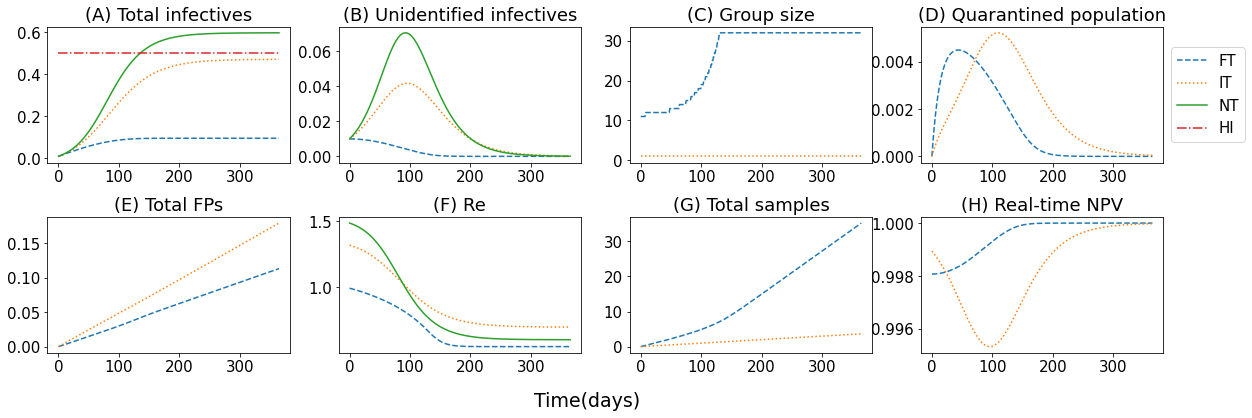

In [202]:
for si in range(len(se)):
  for ri in range(len(x)):
    for ci in range(len(C_0)):
      for pi in range(len(p)):
        # Initial number of infected and recovered individuals, I0 and R0.                
        I0, Q0, R10, R20, TCT0, TFP0 = p[pi],0, 0, 0, 0,0
        S0 = N - I0 - R10 - R20 - Q0 -TFP0               
        y_0 = S0, I0, Q0, R10, R20, TCT0,TFP0
        SIM = []
        T_type = 0
        SIM_FT = Update_integration(y_0, 1, t, N, R_0, gamma_0, C_0[ci], se[si], sp, x[ri])
        SIM = []
        SIM_IT = Update_integration(y_0, 2, t, N, R_0, gamma_0, C_0[ci], se[si], sp, x[ri])
        SIM = []
        SIM_NT = Update_integration(y_0, 0, t, N, R_0, gamma_0, 0, se[si], sp, x[ri])

        fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,6))                    

        axs[0,0].plot(SIM_FT.t,1-SIM_FT.S,label='FT', linestyle='dashed')
        axs[0,0].plot(SIM_IT.t,1-SIM_IT.S,label='IT', linestyle='dotted')
        axs[0,0].plot(SIM_NT.t,1-SIM_NT.S,label='NT', linestyle='solid')
        axs[0,0].set_title('(A) Total infectives')
        axs[0,0].plot(SIM_NT.t,[1-1/R_0 for i in range(len(SIM_NT.t))],label='HI', linestyle='dashdot')                

        axs[0,1].plot(SIM_FT.t,SIM_FT.I,label='FT', linestyle='dashed')
        axs[0,1].plot(SIM_IT.t,SIM_IT.I,label='IT', linestyle='dotted')
        axs[0,1].plot(SIM_NT.t,SIM_NT.I,label='NT', linestyle='solid')
        axs[0,1].set_title('(B) Unidentified infectives')

        axs[0,2].plot(SIM_FT.t,SIM_FT.n,label='FT', linestyle='dashed')
        axs[0,2].plot(SIM_IT.t,SIM_IT.n,label='IT', linestyle='dotted')
        axs[0,2].set_title('(C) Group size') 

        axs[0,3].plot(SIM_FT.t,SIM_FT.Q,label='FT', linestyle='dashed')
        axs[0,3].plot(SIM_IT.t,SIM_IT.Q,label='IT', linestyle='dotted')
        axs[0,3].set_title('(D) Quarantined population')   

        axs[1,0].plot(SIM_FT.t,SIM_FT.TFP,label='FT', linestyle='dashed')
        axs[1,0].plot(SIM_IT.t,SIM_IT.TFP,label='IT', linestyle='dotted')                
        axs[1,0].set_title('(E) Total FPs')                 

        axs[1,1].plot(SIM_FT.t,SIM_FT.Re,label='FT', linestyle='dashed')
        axs[1,1].plot(SIM_IT.t,SIM_IT.Re,label='IT', linestyle='dotted')
        axs[1,1].plot(SIM_NT.t,SIM_NT.Re,label='NT', linestyle='solid')
        axs[1,1].set_title('(F) Re')                 

        axs[1,2].plot(SIM_FT.t,SIM_FT.TCT,label='FT', linestyle='dashed')
        axs[1,2].plot(SIM_IT.t,SIM_IT.TCT,label='IT', linestyle='dotted')                
        axs[1,2].set_title('(G) Total samples')                           

        axs[1,3].plot(SIM_FT.t,SIM_FT.NPV,label='FT', linestyle='dashed')
        axs[1,3].plot(SIM_IT.t,SIM_IT.NPV,label='IT', linestyle='dotted')
        axs[1,3].set_title('(H) Real-time NPV')
                
axs[0,0].legend(loc='center left', bbox_to_anchor=(4.6, 0.5),ncol=1,)
fig.text(0.5, 0,'Time(days)', ha='center',fontsize=19 )
plt.subplots_adjust( hspace =0.4)
plt.savefig('Fig2.pdf',bbox_inches = 'tight')


## Simulation and Plot Figure 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in multiply



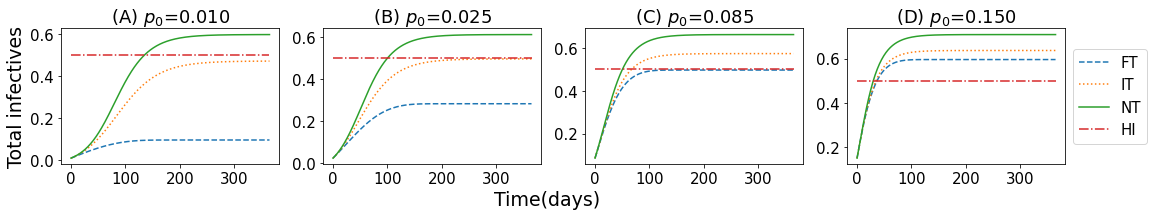

In [203]:
p = [0.01, 0.025,0.085,0.15]
tit_lis = ['A','B','C','D']

for si in range(len(se)):
  for ri in range(len(x)):
    for ci in range(len(C_0)):
      fig = plt.figure(figsize=(18,2.5))
      for pi in range(len(p)):
        # Initial number of infected and recovered individuals, I0 and R0.                
        I0, Q0, R10, R20, TCT0, TFP0 = p[pi],0, 0, 0, 0,0
        S0 = N - I0 - R10 - R20 - Q0 -TFP0               
        y_0 = S0, I0, Q0, R10, R20, TCT0,TFP0
        SIM = []
        T_type = 0

        SIM_FT = Update_integration(y_0, 1, t, N, R_0, gamma_0, C_0[ci], se[si], sp, x[ri])
        SIM = []
        SIM_IT = Update_integration(y_0, 2, t, N, R_0, gamma_0, C_0[ci], se[si], sp, x[ri])
        SIM = []
        SIM_NT = Update_integration(y_0, 0, t, N, R_0, gamma_0, 0, se[si], sp, x[ri])
                
        ax = fig.add_subplot(1,4,pi+1)
        ax.plot(SIM_FT.t,1-SIM_FT.S,label='FT', linestyle='dashed')
        ax.plot(SIM_IT.t,1-SIM_IT.S,label='IT', linestyle='dotted')
        ax.plot(SIM_NT.t,1-SIM_NT.S,label='NT', linestyle='solid')
        ax.plot(SIM_NT.t,[1-1/R_0 for i in range(len(SIM_NT.t))],label='HI', linestyle='dashdot')
        a = np.linspace(0,300,4)
        ax.set_xticks(a)
        
        ax.set_title('(%s) '%tit_lis[pi]+r'$p_0$=%0.03f'%p[pi])
        if pi==0:
          ax.set_ylabel('Total infectives',fontsize=19)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=1,)


fig.text(0.5, -0.1,'Time(days)', ha='center',fontsize=19)                               
plt.savefig('0902_Fig3.pdf',bbox_inches = 'tight')


## Simulation and Plot Figure 4

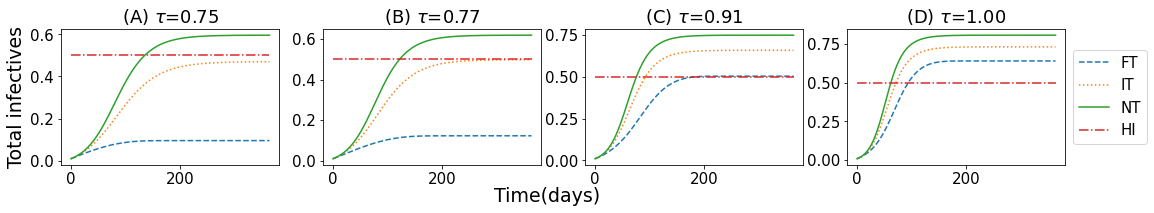

In [204]:
p = [0.01]
x = [0.75,0.77,0.91,1]

for si in range(len(se)):
  for pi in range(len(p)):
    for ci in range(len(C_0)):
      fig = plt.figure(figsize=(18,2.5))
      for ri in range(len(x)):

        # Initial number of infected and recovered individuals, I0 and R0.                
        I0, Q0, R10, R20, TCT0, TFP0 = p[pi],0, 0, 0, 0,0
        S0 = N - I0 - R10 - R20 - Q0 -TFP0               
        y_0 = S0, I0, Q0, R10, R20, TCT0,TFP0
        SIM = []
        T_type = 0

        SIM_FT = Update_integration(y_0, 1, t, N, R_0, gamma_0, C_0[ci], se[si], sp, x[ri])
        SIM = []
        SIM_IT = Update_integration(y_0, 2, t, N, R_0, gamma_0, C_0[ci], se[si], sp, x[ri])
        SIM = []
        SIM_NT = Update_integration(y_0, 0, t, N, R_0, gamma_0, 0, se[si], sp, x[ri])
 
        ax = fig.add_subplot(1,4,ri+1)
        ax.plot(SIM_FT.t,1-SIM_FT.S,label='FT', linestyle='dashed')
        ax.plot(SIM_IT.t,1-SIM_IT.S,label='IT', linestyle='dotted')
        ax.plot(SIM_NT.t,1-SIM_NT.S,label='NT', linestyle='solid')
        ax.plot(SIM_NT.t,[1-1/R_0 for i in range(len(SIM_NT.t))],label='HI', linestyle='dashdot')
        ax.set_title('(%s) '%tit_lis[ri]+r'$\tau$=%0.02f'%x[ri])

        if ri==0:
          ax.set_ylabel('Total infectives',fontsize=19)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=1)

fig.text(0.5, -0.08,'Time(days)', ha='center',fontsize=19)                               
plt.savefig('0902_Fig4.pdf',bbox_inches = 'tight')



## Simulation and Plot Figure 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning:

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations



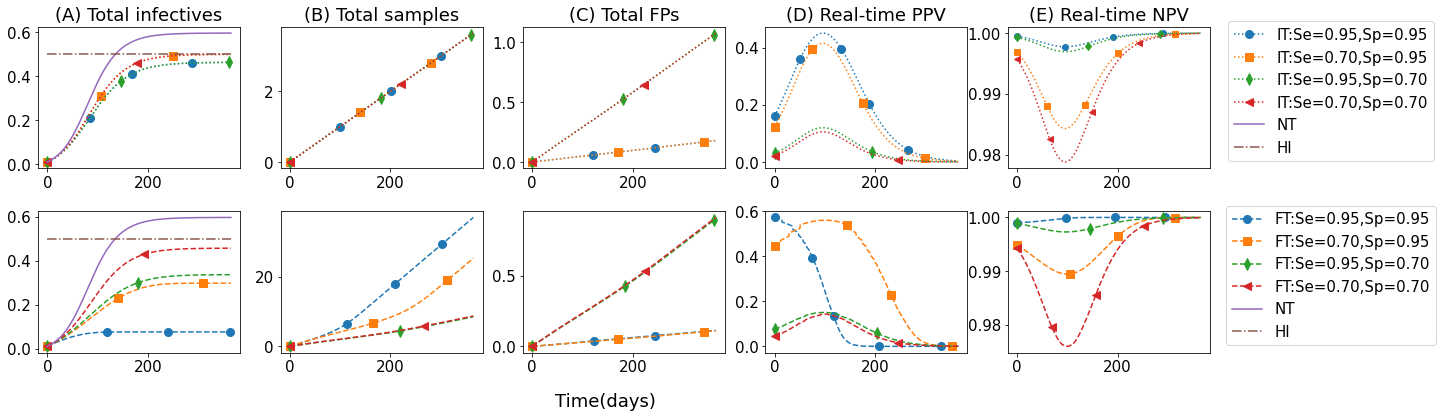

In [205]:
x = [0.75]
sp = [0.95,0.7]
se = [0.95,0.7]

mk = ['o','s','d','<',]


for ri in range(len(x)):
  for pi in range(len(p)):
    for ci in range(len(C_0)):
      count = 0
      fig = plt.figure(figsize=(21,6))

      ax_1 = fig.add_subplot(2,5,1)
      ax_2 = fig.add_subplot(2,5,2)
      ax_3 = fig.add_subplot(2,5,3)
      ax_4 = fig.add_subplot(2,5,4)
      
      ax_5 = fig.add_subplot(2,5,5)
      ax_6 = fig.add_subplot(2,5,6)
      ax_7 = fig.add_subplot(2,5,7)
      ax_8 = fig.add_subplot(2,5,8)    
      ax_9 = fig.add_subplot(2,5,9)
      ax_10 = fig.add_subplot(2,5,10)     
      
      for sj in range(len(sp)):
        SIM = []   
        for si in range(len(se)):
          SIM = []
          count += 1

          # Initial number of infected and recovered individuals, I0 and R0.                
          I0, Q0, R10, R20, TCT0, TFP0 = p[pi],0, 0, 0, 0,0
          S0 = N - I0 - R10 - R20 - Q0 -TFP0               
          y_0 = S0, I0, Q0, R10, R20, TCT0,TFP0
          SIM = []
          T_type = 0

          SIM_FT = Update_integration(y_0, 1, t, N, R_0, gamma_0, C_0[ci], se[si], sp[sj], x[ri])
          SIM = []
          SIM_IT = Update_integration(y_0, 2, t, N, R_0, gamma_0, C_0[ci], se[si], sp[sj], x[ri])
          SIM = []
          SIM_NT = Update_integration(y_0, 0, t, N, R_0, gamma_0, 0, se[si], sp[sj], x[ri])
  
          if (si==0) & (sj == 0):
            ax_1.set_title('(A) Total infectives')
            ax_2.set_title('(B) Total samples')
            ax_3.set_title('(C) Total FPs')                        
            ax_4.set_title('(D) Real-time PPV')          
            ax_5.set_title('(E) Real-time NPV')          
                        
                    
                  
          ax_1.plot(SIM_IT.t,1-SIM_IT.S,label='IT:Se=%0.2f,Sp=%0.2f'%(se[si],sp[sj]), linestyle='dotted', marker=mk[count-1],markersize=8, markevery = 0.15+count/10)                                        
          ax_2.plot(SIM_IT.t,SIM_IT.TCT,label='IT:Se=%0.2f,Sp=%0.2f'%(se[si],sp[sj]), linestyle='dotted', marker=mk[count-1],markersize=8, markevery = 0.15+count/10)
          ax_3.plot(SIM_IT.t,SIM_IT.TFP,label='IT:Se=%0.2f,Sp=%0.2f'%(se[si],sp[sj]),  linestyle='dotted', marker=mk[count-1],markersize=8, markevery = 0.15+count/10)
          ax_4.plot(SIM_IT.t,SIM_IT.PPV,label='IT:Se=%0.2f,Sp=%0.2f'%(se[si],sp[sj]),  linestyle='dotted', marker=mk[count-1],markersize=8, markevery = 0.15+count/10)
          ax_5.plot(SIM_IT.t,SIM_IT.NPV,label='IT:Se=%0.2f,Sp=%0.2f'%(se[si],sp[sj]), linestyle='dotted', marker=mk[count-1], markevery = 0.15+count/20)                    

          ax_6.plot(SIM_FT.t,1-SIM_FT.S,label='FT:Se=%0.2f,Sp=%0.2f'%(se[si],sp[sj]), linestyle='dashed', marker=mk[count-1],markersize=8, markevery =0.15+count/10)                    
          ax_7.plot(SIM_FT.t,SIM_FT.TCT,label='FT:Se=%0.2f,Sp=%0.2f'%(se[si],sp[sj]), linestyle='dashed', marker=mk[count-1],markersize=8, markevery = 0.15+count/10)                    
          ax_8.plot(SIM_FT.t,SIM_FT.TFP, label='FT:Se=%0.2f,Sp=%0.2f'%(se[si],sp[sj]), linestyle='dashed', marker=mk[count-1],markersize=8, markevery = 0.15+count/10)
          ax_9.plot(SIM_FT.t,SIM_FT.PPV, label='FT:Se=%0.2f,Sp=%0.2f'%(se[si],sp[sj]), linestyle='dashed', marker=mk[count-1],markersize=8, markevery = 0.15+count/10)
          ax_10.plot(SIM_FT.t,SIM_FT.NPV,label='GT:Se=%0.2f,Sp=%0.2f'%(se[si],sp[sj]), linestyle='dashed', marker=mk[count-1],markersize=8, markevery = 0.15+count/20)


 
    ax_1.plot(SIM_NT.t,1-SIM_NT.S,label='NT', linestyle='solid')
    ax_6.plot(SIM_NT.t,1-SIM_NT.S,label='NT', linestyle='solid')
    ax_1.plot(SIM_NT.t,[1-1/R_0 for i in range(len(SIM_NT.t))],label='HI', linestyle='dashdot')
    ax_6.plot(SIM_NT.t,[1-1/R_0 for i in range(len(SIM_NT.t))],label='HI', linestyle='dashdot')
    ax_1.legend(loc='lower center', bbox_to_anchor=(6.4, 0),ncol=1)  
    ax_6.legend(loc='lower center', bbox_to_anchor=(6.4,0),ncol=1) 
#             ax_1.legend(loc='lower center', bbox_to_anchor=(4,-1),ncol=1)  
            
            
fig.text(0.5,0,'Time(days)', ha='center',fontsize=18 )
fig.tight_layout()#调整整体空白
plt.subplots_adjust( hspace =0.3)#调整子图间距
plt.savefig('0903_Fig5.pdf',bbox_inches = 'tight')




## Simulation and Plot Figure 6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in multiply



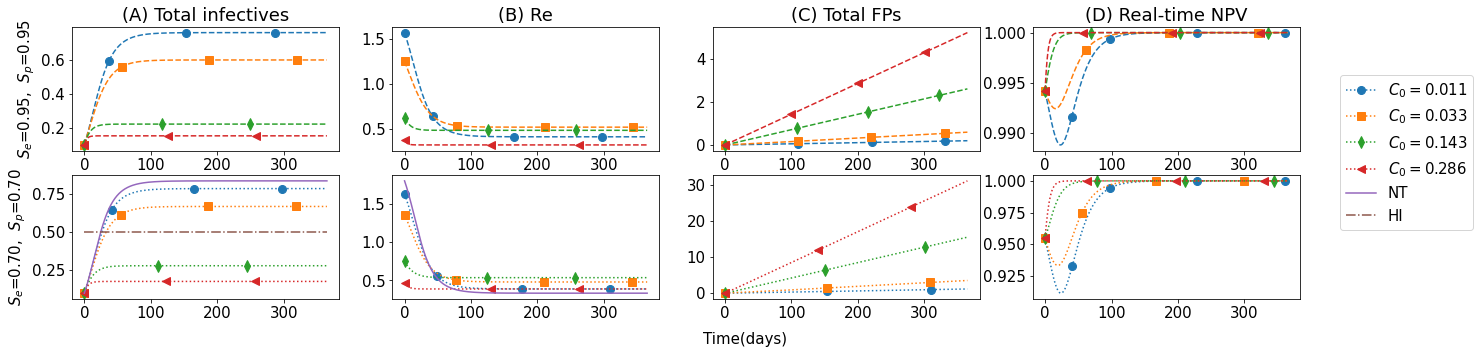

In [206]:
lines = ['dashed','dotted',]

x = [1]
p = [0.1]
se = [0.95,0.7]
sp = [0.95]
C_0 = [0.011,0.033,0.143,0.286]

for ri in range(len(x)):
  for pi in range(len(p)):
    count = 0
    fig = plt.figure(figsize=(22,5))
    for si in range(len(se)):              
      sp = se[si]
      count += 1
      ax_1 = fig.add_subplot(len(se),4,4*(count-1)+1)
      ax_2 = fig.add_subplot(len(se),4,4*(count-1)+2)
      ax_3 = fig.add_subplot(len(se),4,4*(count-1)+3)
      ax_4 = fig.add_subplot(len(se),4,4*(count-1)+4)                
      for ci in range(len(C_0)):
        # Initial number of infected and recovered individuals, I0 and R0.                
        I0, Q0, R10, R20, TCT0, TFP0 = p[pi],0, 0, 0, 0,0
        S0 = N - I0 - R10 - R20 - Q0 -TFP0               
        y_0 = S0, I0, Q0, R10, R20, TCT0,TFP0
        SIM = []

        SIM_FT = Update_integration(y_0, 1, t, N, R_0, gamma_0, C_0[ci], se[si], sp, x[ri])
        SIM = []
        SIM_IT = Update_integration(y_0, 2, t, N, R_0, gamma_0, C_0[ci], se[si], sp, x[ri])
        SIM = []
        SIM_NT = Update_integration(y_0, 0, t, N, R_0, gamma_0, 0, se[si], sp, x[ri])


        ax_1.plot(SIM_IT.t,1-SIM_IT.S,label=r'$C_0=$%0.3f'%C_0[ci], linestyle=lines[si], marker=mk[ci],markersize=8, markevery = 0.3)
        ax_2.plot(SIM_IT.t,SIM_IT.Re,label=r'$C_0=$%0.3f'%C_0[ci],  linestyle=lines[si], marker=mk[ci],markersize=8, markevery = 0.3)
        ax_3.plot(SIM_IT.t,SIM_IT.TFP, label=r'$C_0=$%0.3f'%C_0[ci], linestyle=lines[si], marker=mk[ci],markersize=8, markevery = 0.15+count/10)
        ax_4.plot(SIM_IT.t,(SIM_IT.NPV),label=r'$C_0=$%0.3f'%C_0[ci], linestyle=lines[si], marker=mk[ci],markersize=8, markevery = 0.3)



        ax_1.set_ylabel(r'$S_e$=%0.02f,  $S_p$=%0.02f'%(se[si],sp), rotation=90)
        if (si==0) & (ri == 0):
          ax_1.set_title('(A) Total infectives')
          ax_2.set_title('(B) Re')
          ax_3.set_title('(C) Total FPs')                        
          ax_4.set_title('(D) Real-time NPV')  
    ax_2.plot(SIM_NT.t,SIM_NT.Re,)            
    ax_1.plot(SIM_NT.t,1-SIM_NT.S,label='NT', linestyle='solid')
    ax_1.plot(SIM_NT.t,[1-1/R_0 for i in range(len(SIM_NT.t))],label='HI', linestyle='dashdot')                
  ax_1.legend(loc='lower center', bbox_to_anchor=(5,0.5),ncol=1)  

fig.text(0.55, 0,'Time(days)', ha='center')
# plt.subplots_adjust( hspace =0.3)#调整子图间距
plt.savefig('0903_Fig6.pdf',bbox_inches = 'tight')

